# Лабораторная работа № 4.2

### Задача:

Реализовать метод стрельбы и конечно-разностный метод решения краевой
задачи для ОДУ в виде программ. С использованием разработанного программного
обеспечения решить краевую задачу для обыкновенного дифференциального
уравнения 2-го порядка на указанном отрезке. Оценить погрешность численного
решения с использованием метода Рунге – Ромберга и путем сравнения с точным
решением.

In [1]:
import math, numpy as np, pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

$$ y(x) = - tg(x) $$

In [2]:
def y(x):
    return -np.tan(x)

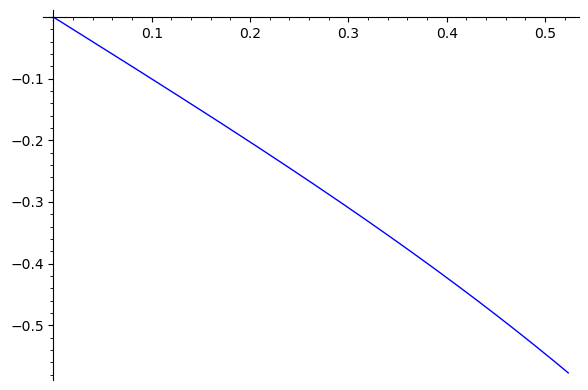

In [3]:
plot(y, (0, math.pi / 6))

In [4]:
class CubicSpline():
    
    def __init__(self, table):
        self.table = list(sorted(table, key=lambda x: x[0]))
        self.coef = []
        
        if len(table) == 2:
            x0, y0, x1, y1 = self.table[0] + self.table[1]
            self.coef = [(y1, (y0-y1) / (x0-x1), 0, 0)]
            return
        
        matrix = [[], [], []]
        b = [0 for _ in range(len(self.table) - 2)]

        for i in range(1, len(self.table) - 1):
            x0, a0 = self.table[i - 1]
            x1, a1 = self.table[i]
            x2, a2 = self.table[i + 1]
            h1, h2 = x1 - x0, x2 - x1

            if 3 == len(self.table):
                matrix[1].append(2 * (h1 + h2))
            else:
                if i == 1:
                    matrix[1].append(2 * (h1 + h2))
                    matrix[2].append(h2)
                elif i == len(self.table) - 2:
                    matrix[0].append(h1)
                    matrix[1].append(2 * (h1 + h2))
                else:
                    matrix[0].append(h1)
                    matrix[1].append(2 * (h1 + h2))
                    matrix[2].append(h2)

            b[i - 1] = 3 * (((a2 - a1) / h2) - ((a1 - a0) / h1))
        
        c = [0] + self._TMA(matrix, b) + [0]
        
        for i in range(1, len(self.table)):
            h1 = self.table[i][0] - self.table[i - 1][0]
            a0 = self.table[i - 1][1]
            a1 = self.table[i][1]
            d1 = (c[i] - c[i - 1]) / (3 * h1)
            b1 = ((a1 - a0) / h1) + h1 * (2 * c[i] + c[i - 1]) / 3

            self.coef.append((a1, b1, c[i], d1))
        
    def _TMA(self, abc, d):
        if len(d) == 1:
            return [d[0] / abc[1][0]]
        dimension = len(d);
        result = [0 for i in range(dimension)]

        P = [0 for i in range(dimension)]
        Q = [0 for i in range(dimension)]
        P[0] = -(abc[2][0] / abc[1][0])
        Q[0] = (d[0] / abc[1][0])

        for i in range(1, dimension - 1):
            P[i] = -(abc[2][i] / (abc[1][i] + abc[0][i - 1] * P[i - 1]))
            Q[i] = ((d[i] - abc[0][i - 1] * Q[i - 1]) / (abc[1][i] + abc[0][i - 1] * P[i - 1]))


        result[dimension - 1] = ((d[dimension - 1] - abc[0][dimension - 2] * Q[dimension - 2]) / (abc[1][dimension - 1] + abc[0][dimension - 2] * P[dimension - 2]))

        for i in range(dimension - 1):
            k = dimension - 2 - i
            result[k] = P[k] * result[k + 1] + Q[k]

        return result
    
    def __call__(self, x):
        if x < self.table[0][0]:
            a, b, c, d = self.coef[0]
            x1 = self.table[1][0]
        elif x > self.table[-1][0]:
            a, b, c, d = self.coef[-1]
            x1 = self.table[-1][0]
        else:    
            for i in range(len(self.table) - 1):
                if self.table[i][0] <= x <= self.table[i + 1][0]:
                    a, b, c, d = self.coef[i]
                    x1 = self.table[i + 1][0]
                    break
                
        return a + b * (x - x1) + c * (x - x1)**2 + d * (x - x1)**3
    
    def plot_table(self):
        return list_plot(self.table)

class RungeKuttaMethod4:
    
    def __init__(self, X0, Y0, F):
        self.X0 = X0
        self.Y0 = Y0
        self.F = F
        self.Table = None
        self.CS = None
        
    def Solve(self, b, h = 0.1):
        
        Table = [(self.X0, self.Y0)]
        
        for x_k in np.arange(self.X0, b, h):
            u_k = Table[-1][1]
            K1 = h * self.F(x_k, *u_k)
            K2 = h * self.F(x_k + .5 * h, *(u_k + .5 * K1))
            K3 = h * self.F(x_k + .5 * h, *(u_k + .5 * K2))
            K4 = h * self.F(x_k + h, *(u_k + K3))
            
            u_kp1 = u_k + (K1 + 2.0 * K2 + 2.0 * K3 + K4) / 6.0
            
            Table.append((x_k + h, u_kp1))
        
        self.Table = np.array([(x, Y[0]) for x, Y in Table])
        return self
    
    def __call__(self, x):
        if self.CS == None:
            self.CS = CubicSpline(list(self.Table))
            
        return self.CS(x)
    
def EPS(Table, fun, tb2 = None, r = 2, p = 2):
    if tb2 is None:
        x = Table[:, :1].T[0]
        y = Table[:, 1:2].T[0]
        return pd.DataFrame(data={'$$x$$': x, '$$y$$': y, '$$y_{ист}$$' : fun(x), '$$\epsilon$$' : np.abs(y - fun(x))})
    
    x = Table[:, :1].T[0]
    y = Table[:, 1:2].T[0]
    eps = ((tb2[:, 1:2] - Table[:, 1:2]) / (r**p - 1)).T[0]
    
    return pd.DataFrame(data={'$$x$$': x, 
                              '$$y$$': y, 
                              '$$y_{ист}$$' : fun(x), 
                              '$$\epsilon$$' : np.abs(y - fun(x)), 
                              '$$\epsilon_{h}$$' : eps})

$
\begin{equation}
 \begin{cases}
   y'' - 2 (1 + tg^2(x)) y = 0,
   \\
   y(0) = 0,
   \\
   y(\frac{\pi}{6}) = -\frac{\sqrt{3}}{3}.
 \end{cases}
\end{equation}
$

$ y'' = f(x, y, y') = 2 (1 + tg^2(x)) y $

$
\begin{equation}
 \begin{cases}
   y' = z,
   \\
   z' = 2 (1 + tg^2(x)) y,
   \\
   y(0) = 0,
   \\
   z(0) = \mu,
   \\
   y(\frac{\pi}{6}) = -\frac{\sqrt{3}}{3}.
 \end{cases}
\end{equation}
$

In [5]:
def u(mu):
    return np.array([
        0,
        mu
    ])

In [6]:
def F(x, y, z):
    return np.array([
        z,
        2 * y * (1 + np.tan(x)**2)
    ])

In [7]:
class ShootingMethod:
    
    def __init__(self, a, u, F, mu1 = 0.0, mu2 = 1.0):
        self.a = a
        self.u = u
        self.F = F
        self.mu1 = mu1
        self.mu2 = mu2
        self.Res = None
        
    def Solve(self, b, ub, h = 0.01, eps = 0.001):
        j = 0
        while True:
            
            rkm1 = RungeKuttaMethod4(self.a, self.u(self.mu1), self.F).Solve(b, h)(b) - ub
            rkm2 = RungeKuttaMethod4(self.a, self.u(self.mu2), self.F).Solve(b, h)(b) - ub
            self.mu1, self.mu2 = self.mu2, self.mu2 - (self.mu2 - self.mu1) / (rkm2 - rkm1) * rkm2
            print(rkm1, rkm2, self.mu2)
            j += 1
            if abs(rkm2) < eps: 
                break
                
        self.Res = RungeKuttaMethod4(self.a, self.u(self.mu2), self.F).Solve(b, h)
        
        return self
    
    def Table(self):
        return self.Res.Table
    
    def __call__(self, x):
        return self.Res(x)

In [8]:
SM = ShootingMethod(0.0, u, F).Solve(math.pi / 6, -1.0/(3**.5), h = math.pi / 6 / 5, eps = 0.001)
SM2 = ShootingMethod(0.0, u, F).Solve(math.pi / 6, -1.0/(3**.5), h = math.pi / 6 / 10, eps = 0.001)

0.5773502691896258 1.1546951031692458 -1.0000094141485052
1.1546951031692458 3.3306690738754696e-16 -1.0000094141485059
0.5773502691896258 1.1547001869114544 -1.0000006087604527
1.1547001869114544 1.1102230246251565e-16 -1.000000608760453


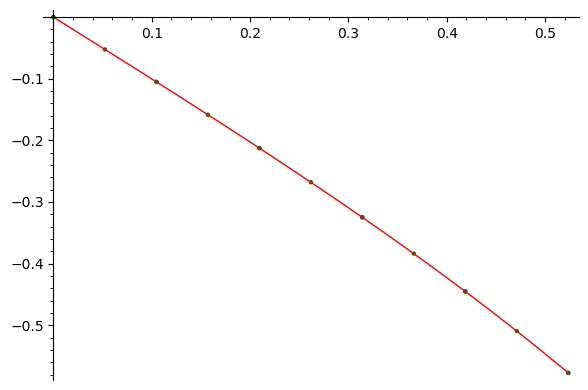

In [9]:
list_plot(SM.Table()) +\
list_plot(SM2.Table(), color = 'green') +\
plot(y, (0, math.pi / 6), color = 'red')

In [10]:
EPS(SM.Table(), y, tb2 = SM2.Table()[::2], p = 4)

,$$x$$,$$y$$,$$y_{ист}$$,$$\epsilon$$,$$\epsilon_{h}$$
0,0.000000,0.000000,-0.000000,0.000000e+00,0.000000e+00
1,0.104720,-0.105105,-0.105104,3.542254e-07,2.201492e-08
2,0.209440,-0.212557,-0.212557,6.584793e-07,4.094901e-08
3,0.314159,-0.324921,-0.324920,8.218377e-07,5.112993e-08
4,0.418879,-0.445229,-0.445229,6.952977e-07,4.327075e-08
5,0.523599,-0.577350,-0.577350,3.330669e-16,1.480297e-17


In [11]:
class FiniteDifferenceMethod:
    
    def __init__(self, p, q, f):
        self.p = p
        self.q = q
        self.f = f
        self.Table = None
        
    def Solve(self, N, a, b, ya, yb):
        matrix = [[], [], []]
        d = []
        
        h = (b - a) / N
        
        for i in range(1, N):
            x = a + i * h
            if i == 1:
                matrix[1].append(-2 + (h**2) * self.q(x))
                matrix[2].append(1 + (h * self.p(x)) / 2)
                d.append((h**2) * self.f(x) - ya * (1 - (h * self.p(x)) / 2))
            elif i == N - 1:
                matrix[0].append(1 - (h * self.p(x)) / 2)
                matrix[1].append(-2 + (h**2) * self.q(x))
                d.append((h**2) * self.f(x) - yb * (1 + (h * self.p(x)) / 2))
            else:
                matrix[0].append(1 - (h * self.p(x)) / 2)
                matrix[1].append(-2 + (h**2) * self.q(x))
                matrix[2].append(1 + (h * self.p(x)) / 2)
                d.append((h**2) * self.f(x))
        
        res = [ya] + self._TMA(matrix, d) + [yb]
        
        self.Table = np.array([[a + i * h, res[i]] for i in range(0, N + 1)])
        
        return self
    
    def _TMA(self, abc, d):
        if len(d) == 1:
            return [d[0] / abc[1][0]]
        dimension = len(d);
        result = [0 for i in range(dimension)]

        P = [0 for i in range(dimension)]
        Q = [0 for i in range(dimension)]
        P[0] = -(abc[2][0] / abc[1][0])
        Q[0] = (d[0] / abc[1][0])

        for i in range(1, dimension - 1):
            P[i] = -(abc[2][i] / (abc[1][i] + abc[0][i - 1] * P[i - 1]))
            Q[i] = ((d[i] - abc[0][i - 1] * Q[i - 1]) / (abc[1][i] + abc[0][i - 1] * P[i - 1]))


        result[dimension - 1] = ((d[dimension - 1] - abc[0][dimension - 2] * Q[dimension - 2]) / (abc[1][dimension - 1] + abc[0][dimension - 2] * P[dimension - 2]))

        for i in range(dimension - 1):
            k = dimension - 2 - i
            result[k] = P[k] * result[k + 1] + Q[k]

        return result

In [12]:
FDM1 = FiniteDifferenceMethod(
    p = lambda _: 0,
    q = lambda x: -2 * (1 + np.tan(x)**2),
    f = lambda _: 0
).Solve(5, 0, math.pi / 6, 0, -1.0/(3**.5))

FDM2 = FiniteDifferenceMethod(
    p = lambda _: 0,
    q = lambda x: -2 * (1 + np.tan(x)**2),
    f = lambda _: 0
).Solve(10, 0, math.pi / 6, 0, -1.0/(3**.5))

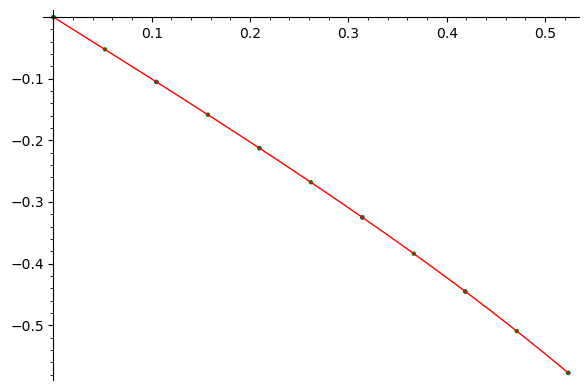

In [13]:
list_plot(FDM1.Table) +\
list_plot(FDM2.Table, color = 'green') +\
plot(y, (0, math.pi / 6), color = 'red')

In [14]:
EPS(FDM1.Table, y, tb2 = FDM2.Table[::2], p = 4)

,$$x$$,$$y$$,$$y_{ист}$$,$$\epsilon$$,$$\epsilon_{h}$$
0,0.000000,0.000000,-0.000000,0.000000e+00,0.000000
1,0.104720,-0.105185,-0.105104,8.034336e-05,0.000004
2,0.209440,-0.212702,-0.212557,1.450362e-04,0.000007
3,0.314159,-0.325094,-0.324920,1.747582e-04,0.000009
4,0.418879,-0.445370,-0.445229,1.414915e-04,0.000007
5,0.523599,-0.577350,-0.577350,1.110223e-16,0.000000
